In [1]:
# Walter Stadolnik and Musheera Khandaker
# Final Project Implementation

# Importing Libraries
from pynq import Overlay
import numpy as np
import random
from pynq import allocate
import csv
import matplotlib.pyplot as plt
import time

In [2]:
# Reading in sample data from .csv
csv_file_path = "ECG_good.csv"
data = []
with open(csv_file_path, newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        data.append(row)

data = data[0]
ecg_sig = [1000*float(x) for x in data[0:2000]]
x = [i for i in range(len(ecg_sig))]

In [3]:
# Defining Filter Coefficients for Software Lowpass Filter (Generated with MATLAB)
# These are hardcoded in a .coe file for the hardware implementation

b_lp = [0.000000495352235,0.000002972113413,0.000007430283531,0.000009907044708,
     0.000007430283531,0.000002972113413,0.000000495352235]
a_lp = [1, -5.271918566723349, 11.619927717930022, -13.702695926669762,
     9.116066297447906, -3.243419845060293, 0.482072025618542]

In [4]:
# Defining Software Direct Form II Filter Function
# - - - - - - - - - - - - - - - - - - - - - - - - - -
def filter_df2t(b, a, x):
    #Initializing Shift Register
    k = max(len(a), len(b))
    shift_reg_v = [0 for i in range(k)]

    #Initializing output sequence
    y = [0 for i in range(len(x))]

    #Looping through data to be filtered
    for i in range(len(x)):
        y[i] = b[0]*x[i] + shift_reg_v[k-2]
        # Multiply-Accumulate Loop
        for j in range(k-2, 0, -1):
            shift_reg_v[j] = shift_reg_v[j-1] + x[i]*b[k-j-1] - y[i]*a[k-j-1]
        shift_reg_v[0] = x[i]*b[k-1] - y[i]*a[k-1]
    return y

In [5]:
# Filtering the signal with Software Lowpass Filter
time1_sw = time.time()
ecg_filt_sw = filter_df2t(b_lp, a_lp, ecg_sig)
time2_sw = time.time()
time_sw = time2_sw-time1_sw

time1_sw = time.time()
ecg_filt_sw = filter_df2t(b_lp, a_lp, ecg_sig)
time2_sw = time.time()
time_sw = time2_sw-time1_sw

print('\nSoftware Time Taken: ', time_sw, 'seconds\n')


Software Time Taken:  0.06449413299560547 seconds



In [6]:
# Setting up the FPGA Direct Form II LP Filter Implementation
stream_overlay = Overlay('/home/xilinx/pynq/overlays/FINAL_PROJECT/lowpass_v2.bit')
stream_overlay?
buf_size = len(ecg_sig)
dma = stream_overlay.filterDMA.axi_dma_0
input_buffer = allocate(shape=(buf_size,), dtype=np.int32)
input_buffer[:]= ecg_sig
output_buffer = allocate(shape=(buf_size,), dtype=np.int32)

In [7]:
def run_kernal():
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [30]:
# Filtering the Signal with Hardware Lowpass Filter
time1_hw = time.time()
run_kernal()
time2_hw = time.time()
time_hw = time2_hw-time1_hw

print('\nHardware Time Taken: ', time_hw, 'seconds\n')

print('The hardware is', time_sw/time_hw, 'times faster than the software.\n')

ecg_filt_hw = [0 for i in range(len(output_buffer))]
for i in range(len(output_buffer)):
    ecg_filt_hw[i] = output_buffer[i]


Hardware Time Taken:  0.0020384788513183594 seconds

The hardware is 9.588771929824562 times faster than the software.



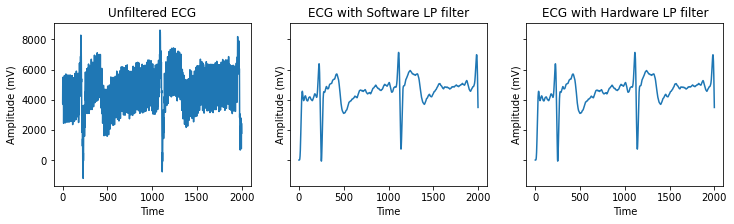

In [9]:
# Plotting the filtered and unfiltered waveforms
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 3))

ax1.plot(x, ecg_sig)
ax1.set_title('Unfiltered ECG')
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude (mV)")

ax2.plot(x, ecg_filt_sw)
ax2.set_title('ECG with Software LP filter')
ax2.set_xlabel("Time")
ax2.set_ylabel("Amplitude (mV)")

ax3.plot(x, ecg_filt_hw)
ax3.set_title('ECG with Hardware LP filter')
ax3.set_xlabel("Time")
ax3.set_ylabel("Amplitude (mV)")
plt.show()

In [10]:
# Defining Filter Coefficients for Software Highpass Filter (Generated with MATLAB)
# These are hardcoded in a .coe file for the hardware implementation

b_hp = [0.998431665916719,-0.998431665916719]
a_hp = [1.000000000000000,-0.996863331833438]

In [11]:
# Filtering the signal with Software HP Filter
time1_sw = time.time()
ecg_filt_sw = filter_df2t(b_hp, a_hp, ecg_filt_sw)
time2_sw = time.time()
time_sw = time2_sw-time1_sw
print('\nSoftware Time Taken: ', time_sw, 'seconds\n')


Software Time Taken:  0.0195465087890625 seconds



In [12]:
# Setting up the FPGA Direct Form II HP Filter Implementation
stream_overlay = Overlay('/home/xilinx/pynq/overlays/FINAL_PROJECT/highpass.bit')
stream_overlay?
buf_size = len(ecg_filt_hw)
dma = stream_overlay.filter_hp.axi_dma_0
input_buffer = allocate(shape=(buf_size,), dtype=np.int32)
input_buffer[:]= ecg_filt_hw
output_buffer = allocate(shape=(buf_size,), dtype=np.int32)

In [24]:
# Filtering the Signal with Hardware HP Filter
time1_hw = time.time()
run_kernal()
time2_hw = time.time()
time_hw = time2_hw-time1_hw



print('\nHardware Time Taken: ', time_hw, 'seconds\n')

print('The hardware is', time_sw/time_hw, 'times faster than the software.\n')

ecg_filt_hw = [0 for i in range(len(output_buffer))]
for i in range(len(output_buffer)):
    ecg_filt_hw[i] = output_buffer[i]


Hardware Time Taken:  0.0021436214447021484 seconds

The hardware is 9.118451785118452 times faster than the software.



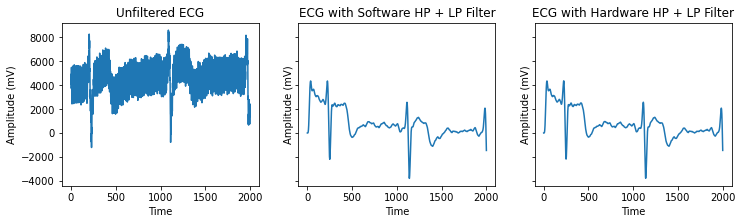

In [14]:
# Plotting the filtered and unfiltered waveforms
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 3))

ax1.plot(x, ecg_sig)
ax1.set_title('Unfiltered ECG')
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude (mV)")

ax2.plot(x, ecg_filt_sw)
ax2.set_title('ECG with Software HP + LP Filter')
ax2.set_xlabel("Time")
ax2.set_ylabel("Amplitude (mV)")

ax3.plot(x, ecg_filt_hw)
ax3.set_title('ECG with Hardware HP + LP Filter')
ax3.set_xlabel("Time")
ax3.set_ylabel("Amplitude (mV)")
plt.show()